In [16]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [17]:
m = pd.read_csv('../dataset/job-matrix.csv', index_col='filename').to_numpy()
pg_total = m[:, 0].sum()
optimal_total = np.min(m, axis=1).sum()
print('pg_total:', pg_total)
print('optimal_total:', optimal_total)

pg_p90 = np.percentile(m[:, 0], 90)
optimal_p90 = np.percentile(np.min(m, axis=1), 90)
print('pg_p90:', pg_p90)
print('optimal_p90:', optimal_p90)

pg_total: 181.0845799446106
optimal_total: 68.0623927116394
pg_p90: 2.9367497920989982
optimal_p90: 1.9514549732208242


In [18]:
def get_data(filename):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []
    cnt = []

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"])
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] - pg_total)
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
            # cnt.append(int(result["explore_queries_cnt"]))
            if "mse" in result:
                mse.append(result["mse"])
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    df = pd.DataFrame({
        "total_latency": total_latency,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time,
    })
    df['overhead_time'] = df['training_time'] + df['inference_time']
    df['overhead_time_cdf'] = df['overhead_time'].cumsum()
    
    if len(mse) > 0:
        df["mse"] = mse
    
    return df

In [19]:
def combine_plot(p_mc_lists, mc_lists):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    
    x_combined = np.linspace(start, end, 5000)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    p25 = np.percentile(fi_list, 25, axis=0)
    p75 = np.percentile(fi_list, 75, axis=0)
    
    return x_combined, y_combined, std, p25, p75

def get_y(x, y, std, p25,p75, x_target):
    x_ = x[x > x_target * 0.6]
    x_ = x_[x_ < x_target * 1.4]
    x_ = x_[len(x_)//2]
    x_index = x.tolist().index(x_)
    return x_, y[x_index], std[x_index], p25[x_index], p75[x_index]

def get_multiple(path, x_name, y_name, n=20):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i))
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x, y, std, p25, p75  = combine_plot(x_list, y_list)
    
    checkpoint_list = [45, 90, 180, 360, 720]
    l = []
    for checkpoint in checkpoint_list:
        l.append(get_y(x, y, std, p25, p75, checkpoint))
        
    return x, y, std, l

In [20]:
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize=16.5
label_fontsize=20
title_fontsize=20
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6", 
    "#d47628", 
    "#8fb943",
    "#d15c6b", 
    "#8481ba", 
    "#413123",  
    "#ffdb58",  
    "#a5a5a5",  
    "#acbfea",  
]

line_styles = ['-', '--', '-.', ':']

[(45.04287762178522, 132.08518752095495, 29.831227325599162, 103.37335490993546, 161.50668784109644), (90.07808489750383, 112.43901799898114, 24.823784528176997, 98.22744810508804, 115.14430879301814), (179.97258067052024, 99.3709527077904, 12.15540191728463, 91.74118987675641, 101.17954192964056), (359.9374909949739, 85.31266575035245, 6.267831458463072, 80.76759952260012, 89.34300205844198), (669.0267846802769, 71.83074532274945, 1.3602603955059787, 70.8694164974323, 72.37461508869319)]
[(45.05126055810995, 128.15888980936717, 33.0263113568133, 95.44096003448735, 150.16657688400312), (90.1025211162199, 109.27145209883159, 24.195287699514566, 87.53005887117783, 119.24857382339565), (180.05924527270483, 92.30361788944752, 7.573068859852854, 84.7476616114878, 99.84107476290684), (359.9726935856747, 81.78946254651984, 4.2999049577383115, 80.9632182495246, 85.92243657417144), (580.563493664705, 73.59277493425992, 2.179645912450691, 71.10624552798353, 75.66379761088075)]


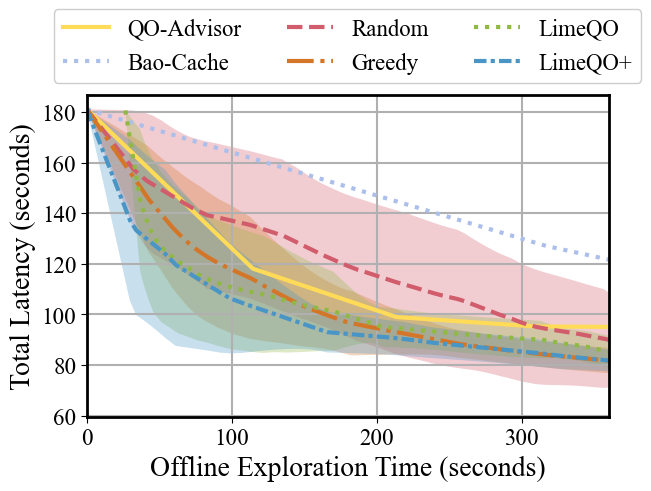

In [21]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

x, y, std, qo_advisor = get_multiple("../experiment/job/qo_advisor/{}.json", "execution_time", "total_latency", n=1)    
ax.plot(x, y, color = color_scheme[6], label='QO-Advisor', linestyle=line_styles[0],  linewidth=linewidth)

x, y, std, bao_cache = get_multiple("../experiment/job/bao_cache/job_bao_cache_{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[8], label='Bao-Cache', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std, random = get_multiple("../experiment/job/random/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[3], label='Random', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std, greedy = get_multiple("../experiment/job/greedy/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[1], label='Greedy', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, y + std, alpha=0.3, color = color_scheme[1], linewidth=0)

x, y, std, limeqo = get_multiple("../experiment/job/limeqo/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='LimeQO', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, y + std, alpha=0.3, color = color_scheme[2], linewidth=0)
print(limeqo)
x, y, std, limeqo_embd = get_multiple("../experiment/job/limeqo+/tcnn_embedding_tcnnratio_timeout1_beta10_rank5_{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[0], label='LimeQO+', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, y + std, alpha=0.3, color = color_scheme[0], linewidth=0)
print(limeqo_embd)
ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_xlim(-0, 360)

ax.set_xlabel('Offline Exploration Time (seconds)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (seconds)', fontsize=label_fontsize, fontweight=fontweight)

plt.savefig('../fig/job.pdf', bbox_inches='tight')

[(45.01286412792507, 151.54156285823274, 27.154679294017505, 124.04331918576864, 176.3162098789486), (90.02572825585014, 138.35613634601367, 29.14701737901542, 112.54175720325156, 168.74502638077814), (180.05145651170028, 119.16345701773753, 28.04070255080609, 95.51540518429987, 151.24898415618293), (359.9567673606476, 89.93160318262412, 18.852939158537954, 79.40748524666833, 88.62742455725636), (581.3674464314478, 73.75393586959035, 2.342275880065542, 72.75422822434199, 74.65992375969975)]
[(45.05891154203016, 143.8505288755763, 21.200913234679142, 132.4832873386369, 156.38553665711282), (90.11782308406032, 120.40824827328822, 25.541872057225838, 102.56812073503231, 132.24557984700223), (180.08982444791988, 96.81831637903878, 12.71300955156037, 88.7514864102709, 99.74330223385898), (360.03382717563903, 81.77329953633604, 5.018945467527005, 77.90602739892894, 84.56894751701748), (580.5162681191653, 73.21055792139133, 2.4272749222114656, 71.29491949858266, 74.21128883419077)]
[(45.04287

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_99989/2395319404.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+labels)


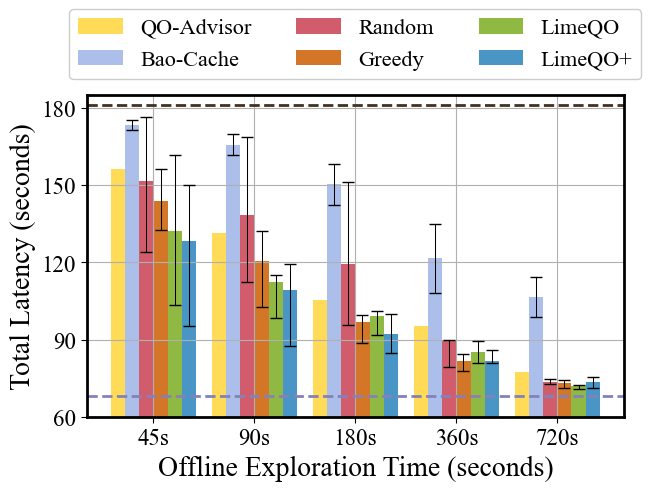

In [22]:
labels = ['45s','90s','180s','360s', '720s']
lines = []
line = ['Random', 'Greedy', 'LimeQO', 'LimeQO+']
lines.append(','.join(line))
print(random)
print(greedy)
print(limeqo)
print(limeqo_embd)
for i in range(5):
    line = [labels[i], random[i][1], greedy[i][1], limeqo[i][1], limeqo_embd[i][1]]
    line = ','.join([str(x) for x in line])
    print(line)
    lines.append(line)

with open('../result/job.csv', "w") as f:
    f.write('\n'.join(lines))
    
# draw a bar plot, each group is a time point, each bar is a method

fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)


x = np.arange(len(labels))
width = 0.14
# draw bar with error bar
print(x)
ax.bar(x - 2.5 * width, [qo_advisor[i][1] for i in range(len(labels))], width, label='QO-Advisor', color=color_scheme[6])
ax.bar(x - 1.5 * width, [bao_cache[i][1] for i in range(len(labels))], width, label='Bao-Cache', color=color_scheme[8], yerr=[[bao_cache[i][2] for i in range(len(labels))], [bao_cache[i][2] for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x - 0.5 * width, [random[i][1] for i in range(len(labels))], width, label='Random', color=color_scheme[3], yerr=[[max(0,random[i][1] - random[i][3]) for i in range(len(labels))],[max(0,random[i][4] - random[i][1]) for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x + 0.5 * width, [greedy[i][1] for i in range(len(labels))], width, label='Greedy', color=color_scheme[1], yerr=[[max(0,greedy[i][1] - greedy[i][3]) for i in range(len(labels))],[max(0,greedy[i][4] - greedy[i][1]) for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x + 1.5 * width, [limeqo[i][1] for i in range(len(labels))], width, label='LimeQO', color=color_scheme[2], yerr=[[max(0,limeqo[i][1] - limeqo[i][3]) for i in range(len(labels))],[max(0,limeqo[i][4] - limeqo[i][1]) for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})
ax.bar(x + 2.5 * width, [limeqo_embd[i][1] for i in range(len(labels))], width, label='LimeQO+', color=color_scheme[0], yerr=[[max(0,limeqo_embd[i][1] - limeqo_embd[i][3]) for i in range(len(labels))],[max(0,limeqo_embd[i][4] - limeqo_embd[i][1]) for i in range(len(labels))]], error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.75})

ax.axhline(pg_total, color = color_scheme[5], linestyle=line_styles[1], linewidth=2) # PG
ax.axhline(optimal_total, color = color_scheme[4], linestyle=line_styles[1], linewidth=2) # Optimal

ax.set_xticklabels([0]+labels)
ax.set_ylim(60, 185)
ax.set_yticks([60, 90, 120, 150, 180])
ax.grid('--')
ax.legend(framealpha=1,fontsize=16, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.set_xlabel('Offline Exploration Time (seconds)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (seconds)', fontsize=label_fontsize, fontweight=fontweight)

fig.savefig('../fig/job_bar.pdf', bbox_inches='tight')

In [23]:
# read from experiment/job/job_bayesqo_opt.csv

df = pd.read_csv('../experiment/job/job_bayesqo_opt.csv')
df

,query_name,cumulative_time,best_runtime
0,JOB_1A,0.092029,0.092029
1,JOB_1A,0.154888,0.062859
2,JOB_1A,0.168428,0.013540
3,JOB_1A,0.181561,0.013132
4,JOB_1A,0.194693,0.013132
...,...,...,...
7397,JOB_33C,20.786650,0.063367
7398,JOB_33C,55.722781,0.063367
7399,JOB_33C,75.571915,0.063367
7400,JOB_33C,92.381573,0.063367


In [24]:
matrix = pd.read_csv('../dataset/job-matrix.csv', index_col='filename')
matrix

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
filename,,,,,,,,,,,,,,,,,,,,,
10a,0.293504,0.289598,0.313582,0.313308,0.372081,0.372081,1.765888,1.458752,1.458752,3.729903,...,2.938778,2.938778,1.781733,0.273029,0.273731,0.313582,0.313308,0.410221,0.410221,1.765888
10b,0.199520,0.199520,0.189664,0.191591,0.207490,0.207490,1.510591,1.766878,1.766878,2.552263,...,1.427519,1.427519,1.499177,0.155783,0.155280,0.193081,0.189505,0.201839,0.201839,1.510591
10c,4.121887,4.121887,4.235231,4.239356,2.042813,2.042813,10.513673,2.042813,2.042813,2.877438,...,3.703589,3.703589,6.339589,5.211753,5.097269,5.336327,5.133626,1.274988,1.274988,10.513673
11a,0.067652,0.067652,0.280765,0.280765,0.079465,0.079465,0.355434,0.126509,0.126509,0.200285,...,0.887990,0.887990,0.386936,0.067652,0.067652,0.071771,0.071771,0.079465,0.079465,0.355434
11b,0.041322,0.041322,0.262582,0.262582,0.047442,0.047442,0.310162,0.598629,0.598629,1.157649,...,0.686520,0.686520,0.365490,0.041322,0.041322,0.066853,0.066853,0.047442,0.047442,0.310162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8d,0.764164,0.784931,1.554868,1.569093,1.329166,1.329166,25.232517,2.423996,2.423996,3.130609,...,5.829999,5.829999,10.814935,7.763718,7.955376,9.466700,9.174238,2.247963,2.247963,25.232517
9a,0.244175,0.244175,1.503808,1.503808,0.243520,0.243520,1.637835,1.940784,1.940784,6.121476,...,3.872777,3.872777,1.641434,0.241620,0.241620,1.503808,1.503808,0.240567,0.240567,1.637835
9b,0.251875,0.251875,1.482064,1.482064,0.252431,0.252431,1.730193,1.780813,1.780813,6.104887,...,3.698243,3.698243,1.737351,0.244430,0.244430,1.482064,1.482064,0.251559,0.251559,1.730193


In [25]:
query_dict = {}
for index, row in matrix.iterrows():
    q = str(index)
    query_dict[q] = {'explore_time': 0, 'total_latency': row[0]}
for index, row in df.iterrows():
    if row['cumulative_time'] < 0.5:
        q = str(row['query_name']).split('_')[1].lower()
        query_dict[q] = {'explore_time': row['cumulative_time'], 'total_latency': row['best_runtime']}

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_99989/2288928492.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query_dict[q] = {'explore_time': 0, 'total_latency': row[0]}


In [26]:
len(query_dict)

113

In [27]:
explore_time = 0
total_latency = 0
for q in query_dict:
    explore_time += query_dict[q]['explore_time']
    total_latency += query_dict[q]['total_latency']

In [28]:
explore_time, total_latency

(31.513378252971425, 178.25356656816732)

In [29]:
# 1	73.84769636	177.0040447
# 2	161.1854961	175.2772059
# 3	260.9655367	175.1840274
# 4	354.1338589	172.873489
# 5	354.1338589	172.873489
# 10	907.0205121	169.7892979
# 15	1364.769603	165.4332868
# 20	1778.519389	162.5311141

bayes_x = [31.513378252971425, 73.84769636, 161.1854961, 260.9655367, 354.1338589, 354.1338589, 907.0205121, 1364.769603, 1778.519389]
bayes_y = [178.25356656816732, 177.0040447, 175.2772059, 175.1840274, 172.873489, 172.873489, 169.7892979, 165.4332868, 162.5311141]

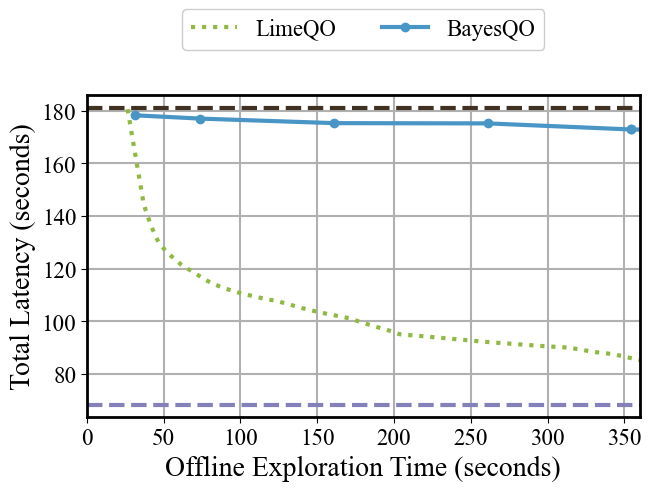

In [30]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

x, y, std, limeqo = get_multiple("../experiment/job/limeqo/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='LimeQO', linestyle=line_styles[3],  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

ax.plot(bayes_x, bayes_y, color = color_scheme[0], marker='o', label='BayesQO', linestyle=line_styles[0],  linewidth=linewidth)

ax.axhline(pg_total, color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
ax.axhline(optimal_total, color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_xlim(-0, 360)
# ax.set_ylim(1.15, 1.5)
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360])

ax.set_ylabel('Total Latency (seconds)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (seconds)', fontsize=label_fontsize, fontweight=fontweight)

plt.savefig('../fig/bayes.pdf', bbox_inches='tight')